In [1]:
from Bio import SeqIO
import pandas as pd
from scipy import stats
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib_venn import venn3
import numpy as np

import re
from collections import defaultdict

In [2]:
seqdict = {}
for record in SeqIO.parse('../data/seqs/cypriniformes_augustus_finz.fa', 'fasta'):
    seqdict[record.id] = str(record.seq)

In [3]:
seqlens = [(key, len(val)) for key, val in seqdict.items()]
length_df = pd.DataFrame(seqlens, columns=['name', 'length'])
print(length_df.head())

                         name  length
0  Anabarilius_grahami_g16.t1     485
1  Anabarilius_grahami_g18.t1     201
2  Anabarilius_grahami_g20.t1     399
3  Anabarilius_grahami_g21.t1     425
4  Anabarilius_grahami_g23.t1     334


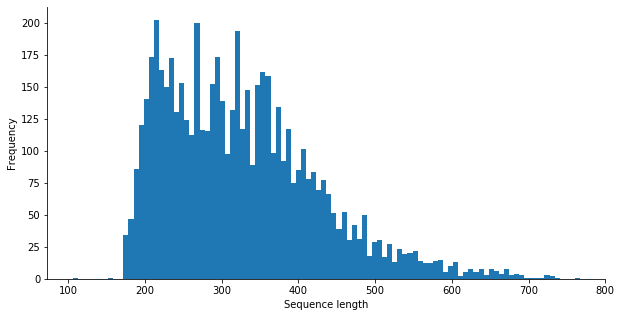

In [4]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(length_df.length, bins=100)
ax.set_xlabel('Sequence length')
ax.set_ylabel('Frequency')
sns.despine()
plt.show()

In [29]:
gff = '../data/gffs/Danio_rerio_finz.final.gff'

exondict = defaultdict(int)

with open(gff) as infile:
    for line in infile:
        if re.match('#', line):
            continue
        if re.search('\tCDS\t', line):
            gene = re.search('ID=transcript:(.+)?\.cds;', line).group(1)
            exondict[f'{gene}'] += 1
exon_df = pd.DataFrame([(key, val) for key, val in exondict.items()], columns=['gene', 'exons'])
exon_df['species'] = 'Danio_rerio'
print(exon_df.head())
print(exon_df.loc[exon_df.species == 'Danio_rerio'].sort_values('exons'))

                 gene  exons      species
0  ENSDART00000111603      2  Danio_rerio
1  ENSDART00000150879      2  Danio_rerio
2              g12.t1      3  Danio_rerio
3              g13.t1      4  Danio_rerio
4  ENSDART00000110358      2  Danio_rerio
                   gene  exons      species
0    ENSDART00000111603      2  Danio_rerio
414            g1422.t1      2  Danio_rerio
413  ENSDART00000168657      2  Danio_rerio
412  ENSDART00000170067      2  Danio_rerio
410  ENSDART00000169391      2  Danio_rerio
..                  ...    ...          ...
87              g261.t1     10  Danio_rerio
190             g643.t1     10  Danio_rerio
602            g2023.t1     10  Danio_rerio
570            g1946.t1     12  Danio_rerio
262             g871.t1     13  Danio_rerio

[817 rows x 3 columns]


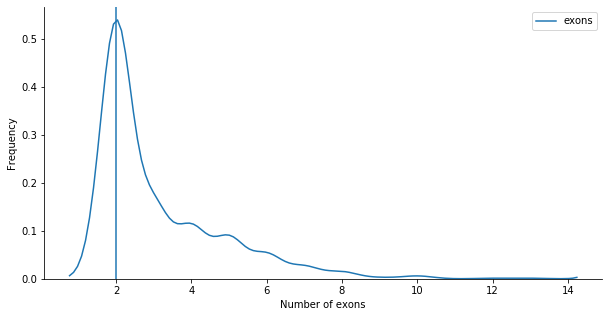

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
# ax.hist(exon_df.exons, bins=len(set(exon_df.exons)), density=True)
# dist.plot.kde(exon_df.exons, ax=ax)
sns.kdeplot(exon_df.loc[exon_df.species == 'Danio_rerio'].exons)
plt.axvline(exon_df.loc[exon_df.species == 'Danio_rerio', 'exons'].median())
ax.set_xlabel('Number of exons')
ax.set_ylabel('Frequency')
sns.despine()
plt.show()


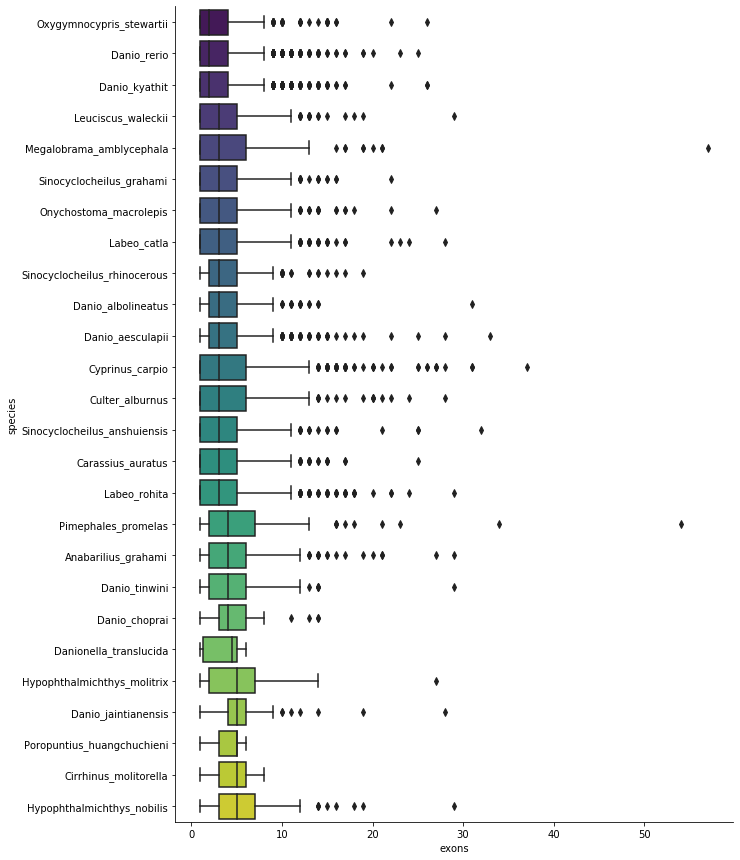

In [7]:
sortorder = exon_df.groupby('species').median().reset_index().sort_values('exons').species.tolist()
fig, ax = plt.subplots(figsize=(10, 15))
sns.boxplot(data=exon_df, x='exons', y='species', order=sortorder, palette='viridis')
sns.despine()
plt.show()

In [8]:
with open('../data/finz_znf_overlap_80.txt') as infile:
    data80 = [int(line.split()[-1]) for line in infile]
# (A, B, AB, C, AC, BC, ABC)
venn3(subsets = data80, 
      set_labels=('denovo', 'ensembl', 'refseq'), 
      set_colors=('purple', 'dodgerblue', 'orange'))
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '../data/finz_znf_overlap_80.txt'

In [32]:
print(522+163+64+69)
print(115+163+64+60)
print(77+69+64+60)

818
402
270
